In [ ]:
# necessary libraries
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from sklearn.model_selection import train_test_split
import pickle
import re
import io
import json

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!pip install tensorflow


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
# from b2_preprocessing_function import CustomPreprocess
from keras.preprocessing.text import tokenizer_from_json
import json

# Import necessary libraries for building neural networks with TensorFlow/Keras
# Sequential: For creating sequential models
# Layers: Various Keras layers like Activation, Dropout, Dense, Flatten, etc.
# Text Processing: Tools for tokenization, one-hot encoding, and sequence padding
# Data Splitting: For splitting data into training and testing sets



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AI/IMDB_Dataset.csv')

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.shape

(50000, 2)

In [ ]:
df.isnull().values.any()

False

In [ ]:
df["review"].duplicated().sum()

418

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df["review"].duplicated().sum()

0


# **Data Preprocessing**

In [ ]:
df["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [ ]:
from nltk.stem import WordNetLemmatizer
import string
import nltk
import re

nltk.download('stopwords')
nltk.download('wordnet')

def clean_data(review):
    # Cleaning operations are performed on the review text

    # Convert review text to lowercase
    review = review.lower()

    # Remove HTML tags (e.g., <br>, <p>)
    review = re.sub(r"<.*?>", " ", review)

    # Remove punctuation characters
    review = review.translate(str.maketrans('', '', string.punctuation))

    # Initialize WordNet lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Initialize list to store cleaned words
    cleaned_text = []

    # Tokenize the review text and iterate over each word
    for word in review.split():
        # Check if the word is not a stopword and not numeric
        if word not in stopwords.words('english') and not word.isnumeric():
            # Lemmatize the word and append it to the cleaned_text list
            cleaned_text.append(lemmatizer.lemmatize(word))

    # Join the cleaned words to form a cleaned review string
    cleaned_review = " ".join(cleaned_text)

    return cleaned_review

# assigning the clean data to X
X = df['review'].apply(clean_data).tolist()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
X[6]

'sure would like see resurrection dated seahunt series tech today would bring back kid excitement mei grew black white tv seahunt gunsmoke hero every weekyou vote comeback new sea huntwe need change pace tv would work world water adventureoh way thank outlet like view many viewpoint tv many moviesso ole way believe ive got wanna saywould nice read plus point sea huntif rhyme would line would let submitor leave doubt quitif must go let'

In [ ]:
print(clean_data(df.review[0]))

one reviewer mentioned watching oz episode youll hooked right exactly happened first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home manyaryans muslim gangsta latino christian italian irish moreso scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show wouldnt dare forget pretty picture painted mainstream audience forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard wholl sold nickel inmate wholl kill order get away well mannered middle class inmate turned prison bitch due lac

In [ ]:
#now we need to convert the sentiment labels into 0 and 1

y = df['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

135688

In [ ]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
from gensim.downloader import load

# Download and load GloVe embeddings
glove_model = load('glove-wiki-gigaword-100')

# Create an embeddings dictionary
embeddings_dictionary = {}
for word in glove_model.index_to_key:
    embeddings_dictionary[word] = glove_model[word]


[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
# Create Embedding Matrix
from numpy import zeros
embeddings_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embeddings_matrix[index] = embedding_vector

In [ ]:
embeddings_matrix.shape

(135688, 100)

In [ ]:
# Check the sizes of vocab_length and the tokenizer's word index
print("Vocabulary size:", vocab_length)
print("Number of unique words in tokenizer's word index:", len(word_tokenizer.word_index))

# Adjust vocab_length if necessary
vocab_length = len(word_tokenizer.word_index) + 1  # Add 1 to account for the reserved index 0


Vocabulary size: 135688
Number of unique words in tokenizer's word index: 135687


#  Model Training


In [ ]:
from keras.layers import LSTM

In [ ]:
model = Sequential()


# Recreate the embedding layer with the corrected vocab_length
embedding_layer = Embedding(vocab_length, 100, weights=[embeddings_matrix], input_length=maxlen, trainable=False)

model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          13568800  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 13686177 (52.21 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 13568800 (51.76 MB)
_________________________________________________________________
None


In [ ]:
# Model Training

lstm_model_history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
248/248 [==============================] - 92s 359ms/step - loss: 0.5172 - acc: 0.7498 - val_loss: 0.4687 - val_acc: 0.8079
Epoch 2/6
248/248 [==============================] - 82s 330ms/step - loss: 0.4291 - acc: 0.8077 - val_loss: 0.4282 - val_acc: 0.8110
Epoch 3/6
248/248 [==============================] - 79s 319ms/step - loss: 0.3787 - acc: 0.8354 - val_loss: 0.3704 - val_acc: 0.8486
Epoch 4/6
248/248 [==============================] - 80s 322ms/step - loss: 0.3410 - acc: 0.8536 - val_loss: 0.3572 - val_acc: 0.8547
Epoch 5/6
248/248 [==============================] - 82s 332ms/step - loss: 0.3227 - acc: 0.8643 - val_loss: 0.3345 - val_acc: 0.8560
Epoch 6/6
248/248 [==============================] - 85s 344ms/step - loss: 0.3052 - acc: 0.8718 - val_loss: 0.3309 - val_acc: 0.8589


In [ ]:
# Predictions on the Test Set

score = model.evaluate(X_test, y_test, verbose=1)

310/310 [==============================] - 17s 56ms/step - loss: 0.3377 - acc: 0.8547


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3377326428890228
Test Accuracy: 0.8546939492225647


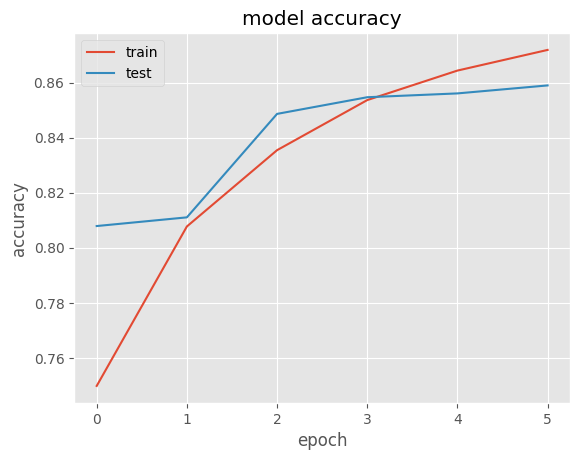

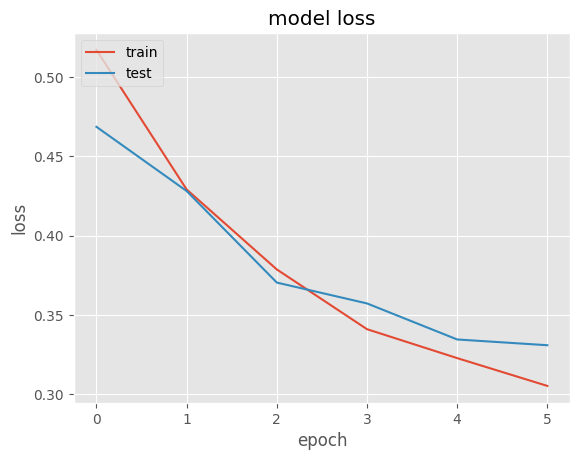

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
from keras.preprocessing.sequence import pad_sequences

def prediction(review, model, preprocessor, tokenizer, maxlen=100):
    # Preprocess the review
    preprocessed_review = preprocessor(review)

    # Tokenize and pad the review
    tokenized_review = tokenizer.texts_to_sequences([preprocessed_review])
    padded_review = pad_sequences(tokenized_review, maxlen=maxlen)

    # Predict sentiment using the model
    predicted_sentiment = model.predict(padded_review)

    # Determine sentiment label based on the predicted value
    if predicted_sentiment[0][0] > 0.5:  # Assuming > 0.5 is positive
        result = "Positive"
    else:
        result = "Negative"

    return result


In [ ]:
# Example usage
review = "This movie was so boring. I hate it"
predicted_sentiment = prediction(review, model, clean_data, word_tokenizer)
print("Predicted Sentiment:", predicted_sentiment)



1/1 [==============================] - 0s 37ms/step
Predicted Sentiment: Negative
